<a href="https://colab.research.google.com/github/sergiomora03/AdvancedTopicsAnalytics/blob/main/notebooks/L12-DeepLearning_keras_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Deep Learning using keras

This notebook is licensed under a [Creative Commons Attribution-ShareAlike 3.0 Unported License](http://creativecommons.org/licenses/by-sa/3.0/deed.en_US). Special thanks goes to [Valerio Maggio](https://mpba.fbk.eu), Fondazione Bruno Kessler, [Alejandro Correa Bahnsen](albahnsen.com/) and [Jesus Solano](https://github.com/jesugome)

<img src="https://raw.githubusercontent.com/sergiomora03/AdvancedMethodsDataAnalysisClass/68b4cc50f2cba5e389d7fa75afe7a5e658c38086/notebooks/images/keras-logo-small.jpg" width="20%" />

## Keras: Deep Learning library for Theano and TensorFlow

>Keras is a minimalist, highly modular neural networks library, written in Python and capable of running on top of either TensorFlow or Theano.

>It was developed with a focus on enabling fast experimentation. Being able to go from idea to result with the least possible delay is key to doing good research.
ref: https://keras.io/

### SMS Spam Collection Data

##### For this section we will use the SMS Spam Collection. This is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam.

# Single Layer Neural Network


## Data Preparation

In [2]:
!pip install wget
!pip install livelossplot --quiet

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=8e7a5e01d9d5516c23b87534f52ef5e9b056f5b3db15203ddbe25bf4ac9f5a00
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [3]:
import pandas as pd
import numpy as np
import wget
import os
from zipfile import ZipFile

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import string

from sklearn.model_selection import train_test_split

from keras import backend as K
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.utils import pad_sequences
from livelossplot import PlotLossesKeras

import matplotlib.pyplot as plt
import warnings


warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
try :
    from google.colab import files
    !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
    !unzip smsspamcollection.zip
    df = pd.read_csv('SMSSpamCollection', sep='\t',  header=None, names=['target', 'text'])
except ModuleNotFoundError :
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
    path = os.getcwd()+'\Data'
    wget.download(url,path)
    temp=path+'\smsspamcollection.zip'
    file = ZipFile(temp)
    file.extractall(path)
    file.close()
    df = pd.read_csv(path + '\SMSSpamCollection', sep='\t',  header=None, names=['target', 'text'])

--2025-04-05 14:11:29--  https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘smsspamcollection.zip’

smsspamcollection.z     [  <=>               ] 198.65K   744KB/s    in 0.3s    

2025-04-05 14:11:29 (744 KB/s) - ‘smsspamcollection.zip’ saved [203415]

Archive:  smsspamcollection.zip
  inflating: SMSSpamCollection       
  inflating: readme                  


In [5]:
df.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
X = df['text']
y = df['target'].map({'ham':0, 'spam':1})

In [7]:
import nltk
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [8]:
stop_words = set(stopwords.words('english'))
def preprocess(text):
    text = text.lower()
    text = ''.join([word for word in text if word not in string.punctuation])
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

X = X.apply(preprocess)

### Create vocabulary

In [9]:
X = X.tolist()

In [10]:
# For vocabulary only the intersec characters is used to avoid issues with data collection
voc = set(''.join(X))
vocabulary = {x: idx + 1 for idx, x in enumerate(set(voc))}

### Create Embedding

In [11]:
# Max len
max_len = 150
X = [x[:max_len] for x in X]
# Convert characters to int and pad
X = [[vocabulary[x1] for x1 in x if x1 in vocabulary.keys()] for x in X]

In [12]:
len(X)

5572

In [20]:
X_pad = pad_sequences(X, maxlen=max_len)

In [21]:
X_pad

array([[ 0,  0,  0, ..., 29, 12,  1],
       [ 0,  0,  0, ...,  8, 25, 30],
       [ 0,  0,  0, ..., 22, 23, 39],
       ...,
       [ 0,  0,  0, ...,  8, 25, 39],
       [ 0,  0,  0, ..., 55, 24, 24],
       [ 0,  0,  0, ..., 12, 16, 24]], dtype=int32)

In [22]:
# split data into training and validation set
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, stratify = df['target'], test_size = 0.3, random_state = 18)

---

# Using Keras

In [23]:
learning_rate = 0.01

In [24]:
model = Sequential()
model.add(Embedding(len(vocabulary) + 1, 128, input_length=max_len))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Be more specific with hyperparameters...

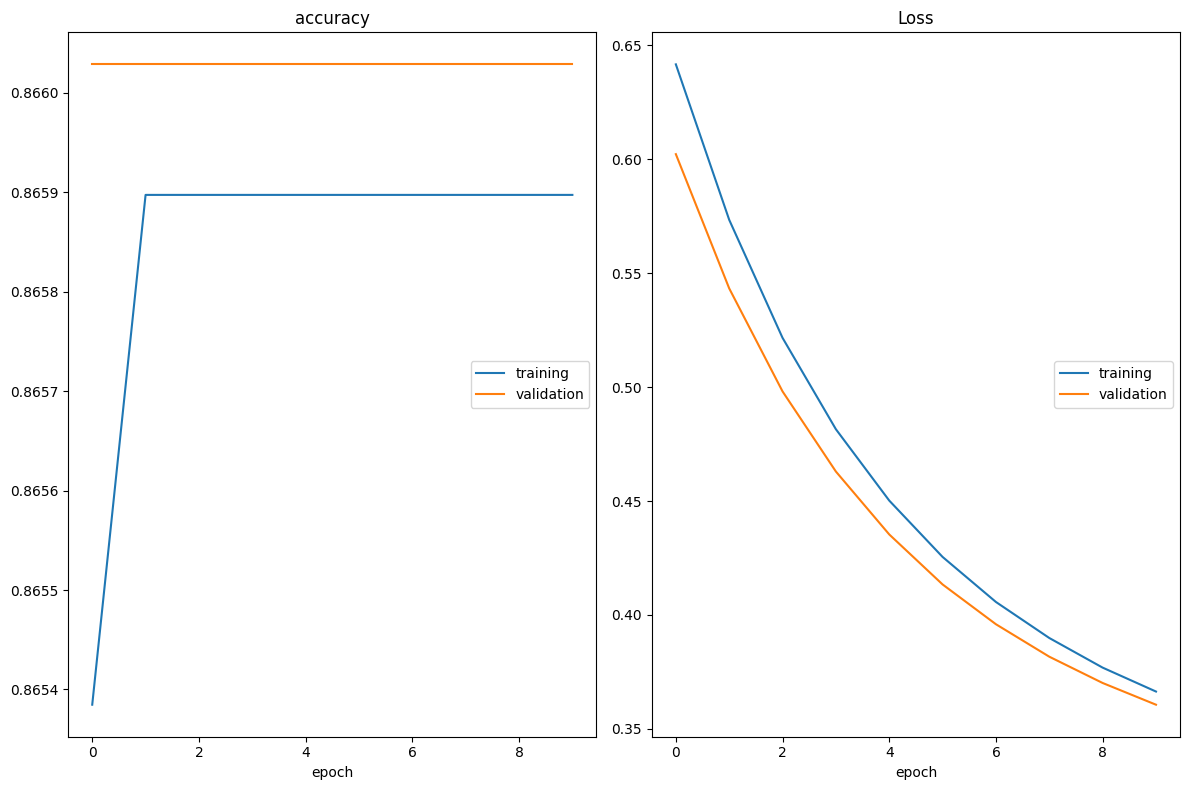

accuracy
	training         	 (min:    0.865, max:    0.866, cur:    0.866)
	validation       	 (min:    0.866, max:    0.866, cur:    0.866)
Loss
	training         	 (min:    0.366, max:    0.642, cur:    0.366)
	validation       	 (min:    0.361, max:    0.602, cur:    0.361)
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8695 - loss: 0.3658 - val_accuracy: 0.8660 - val_loss: 0.3606


In [25]:
from keras.models import Sequential
from keras.layers import Embedding, GlobalAveragePooling1D, Dense
from keras import backend as K
import keras.optimizers as opts

K.clear_session()

model = Sequential()
model.add(Embedding(input_dim=len(vocabulary) + 1, output_dim=128, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(1, activation='sigmoid'))

op = opts.SGD(learning_rate=learning_rate)

model.compile(loss='binary_crossentropy', optimizer=op, metrics=['accuracy'])

model.summary()



model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          batch_size=128, epochs=10, verbose=1,
          callbacks=[PlotLossesKeras()])


What we did here is stacking a Fully Connected (<b>Dense</b>) layer of trainable weights from the input to the output and an <b>Activation</b> layer on top of the weights layer.

---

Let's see first the model we implemented

In [26]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 150, 128)            │           7,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,811 (30.52 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [27]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

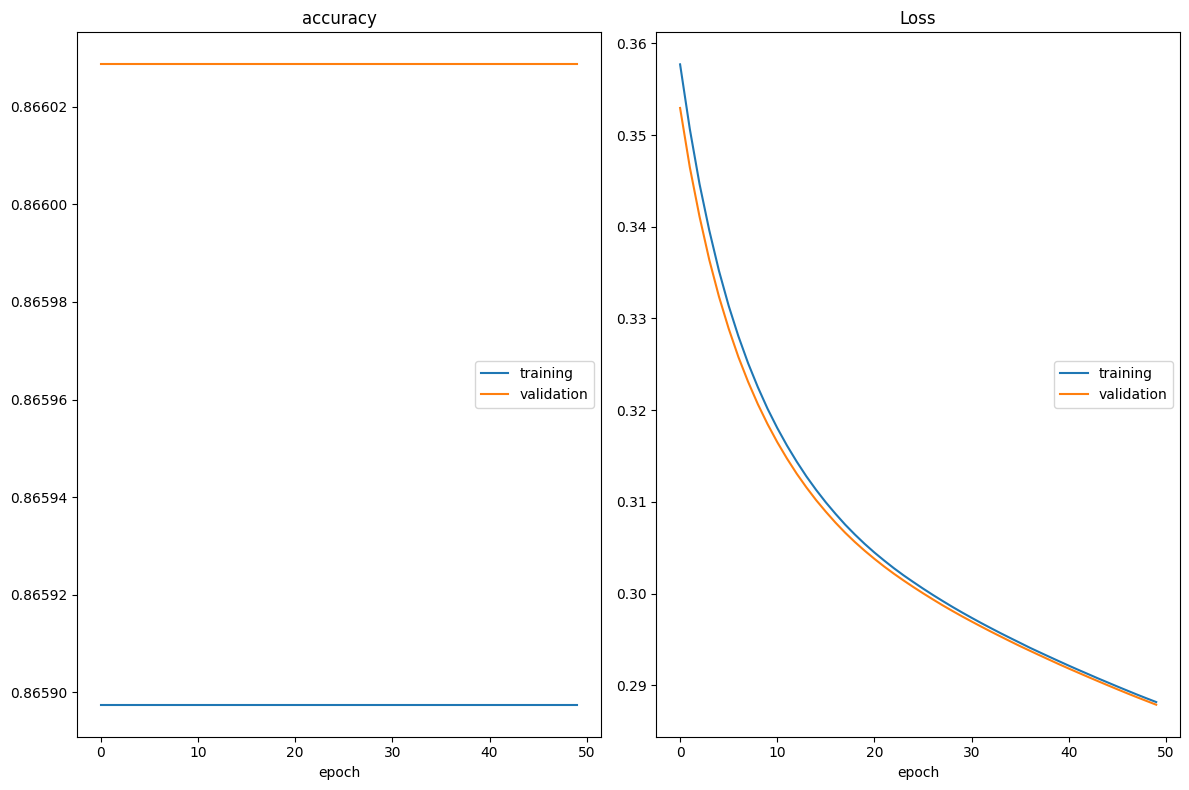

accuracy
	training         	 (min:    0.866, max:    0.866, cur:    0.866)
	validation       	 (min:    0.866, max:    0.866, cur:    0.866)
Loss
	training         	 (min:    0.288, max:    0.358, cur:    0.288)
	validation       	 (min:    0.288, max:    0.353, cur:    0.288)
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8711 - loss: 0.2803 - val_accuracy: 0.8660 - val_loss: 0.2879


In [28]:
fBestModel = 'best_model.keras'
early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
best_model = ModelCheckpoint(fBestModel, verbose=0, save_best_only=True)

model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          epochs=50,
          batch_size=128, verbose=True, callbacks=[best_model, early_stop, PlotLossesKeras()])

# Multi-Layer Fully Connected Networks

**Q:** _How hard can it be to build a Multi-Layer Fully-Connected Network with keras?_

**A:** _It is basically the same, just add more layers!_

In [29]:
K.clear_session()
print("Building model...")
model = Sequential()
model.add(Embedding(len(vocabulary) + 1, 128, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(256,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])
model.summary()

Building model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ ?                           │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

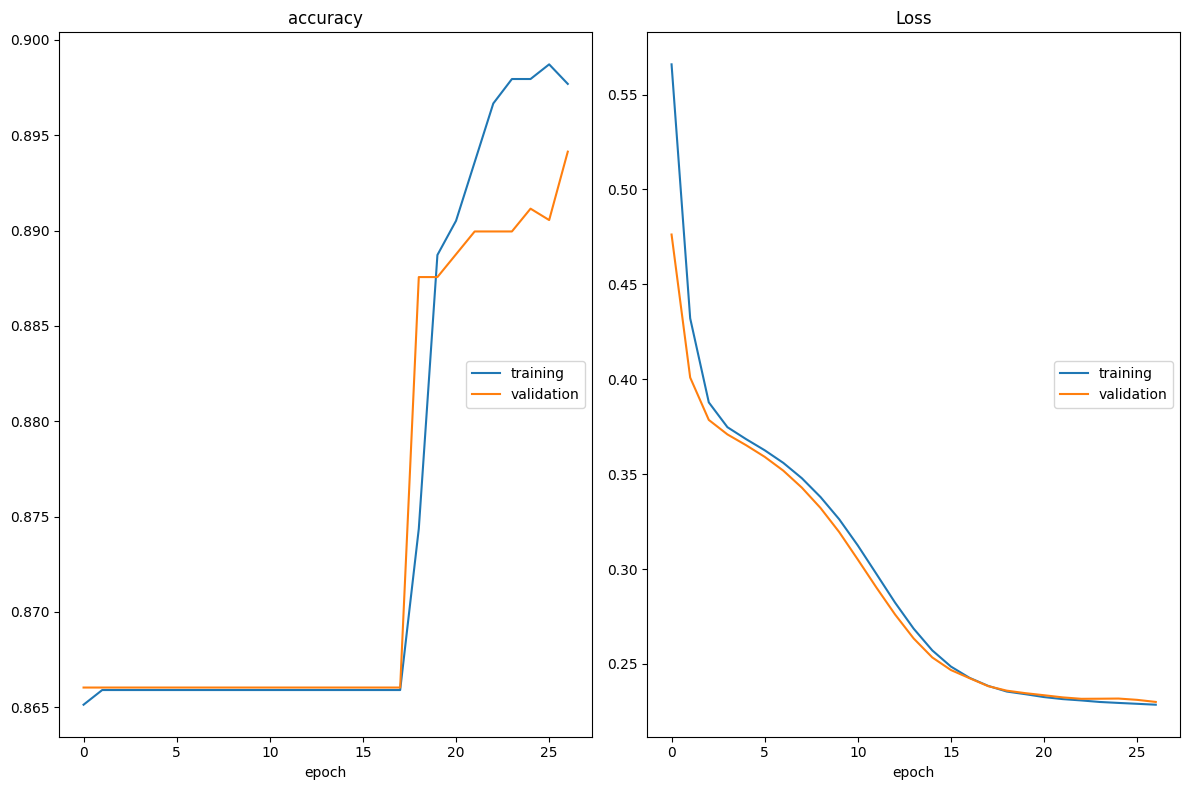

accuracy
	training         	 (min:    0.865, max:    0.899, cur:    0.898)
	validation       	 (min:    0.866, max:    0.894, cur:    0.894)
Loss
	training         	 (min:    0.229, max:    0.566, cur:    0.229)
	validation       	 (min:    0.230, max:    0.476, cur:    0.230)
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9029 - loss: 0.2238 - val_accuracy: 0.8941 - val_loss: 0.2300
Epoch 28/50
120/122 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8990 - loss: 0.2256

In [ ]:
model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          epochs=50,
          callbacks=[PlotLossesKeras()])

In [ ]:
model.summary()

What does the cost function behavior mean over the traning in the above plot?

---

# Your Turn!

## Hands On - Keras Fully Connected


Take couple of minutes and try to play with the number of layers and the number of parameters in the layers to get the best results.

In [ ]:
K.clear_session()
print("Building model...")
model = Sequential()
model.add(Embedding(len(vocabulary) + 1, 128, input_length=max_len))

# ...
# ...
# Play with it! add as much layers as you want! try and get better results.

model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])
model.summary()


In [ ]:
model.fit(X_train, Y_train,
          validation_data = (X_val, Y_val),
          epochs=50,
          callbacks=[PlotLossesKeras()])